# [Learn Quantum Computing with Python and Q#](https://www.manning.com/books/learn-quantum-computing-with-python-and-q-sharp?a_aid=learn-qc-granade&a_bid=ee23f338)<br>Chapter 8 Exercise Solutions
----
> Copyright (c) Sarah Kaiser and Chris Granade.
> Code sample from the book "Learn Quantum Computing with Python and Q#" by
> Sarah Kaiser and Chris Granade, published by Manning Publications Co.
> Book ISBN 9781617296130.
> Code licensed under the MIT License.

### Preamble

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import qsharp

### Exercise 8.1

**In Chapter 4, you used Python type annotations to represent the concept of a _strategy_ in the CHSH game.
User-defined types in Q# can be used in a similar fashion.
Give it a go by defining a new UDT for CHSH strategies and then use your new UDT to wrap the constant strategy from Chapter 4.**

*HINT*: Your and Eve's parts of the strategy can each be represented as operations that take a `Result` and output a `Result`.
That is, as operations of type `Result => Result`.

In [2]:
strategy = qsharp.compile("""
    newtype Strategy = (
        PlayAlice: (Result => Result),
        PlayBob: (Result => Result)
    );
""")
strategy

<Q# callable Strategy>

----
### Exercise 8.2

**You can find the model for Lancelot's results if you use Born's rule!
We have put the definition from Chapter 2 below, see if you can plot the resulting value as a function of Lancelot's scale using Python.
Does your plot look like a trigonometric function?**

\begin{align}
    \Pr(\text{measurement} | \text{state}) = |\left\langle \text{measurement} \mid \text{state} \right\rangle|^2
\end{align}

*HINT*: For Lancelot's measurements, the $\left\langle \text{measurement} \right|$ part of Born's rule is given by $\left\langle 1 \right|$.
Immediately before measuring, his qubit will be in the state $H R_1(\theta * \textrm{scale}) H \left|0\right\rangle$.
You can simulate the `R1` operation in QuTiP by using the matrix form in the Q# reference at https://docs.microsoft.com/qsharp/api/qsharp/microsoft.quantum.intrinsic.r1.

For the purposes of illustration, let's choose $\theta = 0.456$ radians.

In [3]:
theta = 0.456

Next, as the hint gives us, we'll need to define a matrix that we can use to simulate the `R1` operation:

In [4]:
def r1_matrix(angle: float) -> qt.Qobj:
    return qt.Qobj([
        [1, 0],
        [0, np.exp(1j * angle)]
    ])

In [5]:
r1_matrix(theta)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.89782112+0.44036035j]]

We can use this to find Lancelot's state after applying each hidden rotation:

In [6]:
def lancelot_final_state(theta: float, scale: float) -> qt.Qobj:
    initial_state = qt.basis(2, 0)
    # Simulate the H Q# operation.
    state = qt.qip.operations.hadamard_transform() * initial_state
    # Simulate the R1 operation.
    state = r1_matrix(theta * scale) * state
    # Simulate undoing the H operation with another call to H.
    state = qt.qip.operations.hadamard_transform() * state
    
    return state

In [7]:
lancelot_final_state(theta, 1.2)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.92699235+0.26014906j]
 [0.07300765-0.26014906j]]

We now have everything we need to predict the probability of a "1" outcome:

In [8]:
def lancelot_pr1(theta: float, scale: float) -> float:
    ket1 = qt.basis(2, 1)
    
    # Apply Born's rule.
    return np.abs((ket1.dag() * lancelot_final_state(theta, scale))[0, 0]) ** 2

In [9]:
lancelot_pr1(theta, 1.2)

0.07300764875288458

Plotting for a variety of different scales, we see the expected sinusoidal shape:

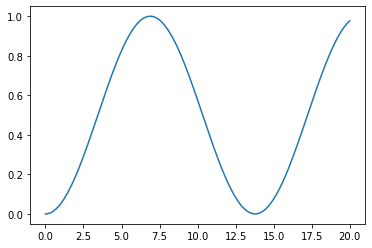

In [10]:
scales = np.linspace(0, 20, 201)
pr1s = [lancelot_pr1(theta, scale) for scale in scales]
plt.plot(scales, pr1s)

----
### Exercise 8.3

**Try writing Q# programs that use `AssertQubit` and `DumpMachine` to verify that:**

- $\left|+\right\rangle$ and $\left|-\right\rangle$ are both eigenstates of the `X` operation.
- $\left|0\right\rangle$ and $\left|1\right\rangle$ are both eigenstates of the `Rz` operation, regardless of what angle you choose to rotate by.

For even more practice, try figuring out what the eigenstates of the `Y` and `CNOT` operations and writing a Q# program to verify your guesses!

*HINT*: You can find the vector form of the eigenstates of a unitary operation using QuTiP.
For instance, the eigenstates of the `Y` operation are given by `qt.sigmay().eigenstates()`.
From there, you can use what you learned about rotations in Chapters 4 and 5 to figure out which Q# operations prepare those states.

Don't forget you can always test if a particular state is an eigenstate of an operation by just writing a quick test in Q#!  

Let's start by verifying that $\left|+\right\rangle$ and $\left|-\right\rangle$ are both eigenstates of the `X` operation.

In [11]:
verify_x_eigenstates = qsharp.compile("""
    open Microsoft.Quantum.Diagnostics;
    
    operation VerifyXEigenstates() : Unit {
        using (q = Qubit()) {
            // Prepare |+⟩.
            H(q);

            // Check that the X operation does nothing.
            X(q);
            Message("Checking that |+⟩ is an eigenstate of the X operation.");
            DumpMachine();
            
            // Reset so that we're ready for the next check.
            Reset(q);
            
            // Next, do the same with |−⟩.
            X(q);
            H(q);
            
            X(q);
            Message("");
            Message("Checking that |−⟩ is an eigenstate of the X operation.");
            DumpMachine();
            
            Reset(q);
        }
    }
""")

In [12]:
verify_x_eigenstates.simulate()

Checking that |+⟩ is an eigenstate of the X operation.
|0⟩	0.7071067811865476 + 0𝑖
|1⟩	0.7071067811865476 + 0𝑖
Checking that |−⟩ is an eigenstate of the X operation.
|0⟩	-0.7071067811865476 + 0𝑖
|1⟩	0.7071067811865476 + 0𝑖

()

Notice that in both cases, we got back the same state (up to a global phase), confirming the first part of the exercise.
Doing the same for `Rz`, we add an input for the rotation angle:

In [13]:
verify_rz_eigenstates = qsharp.compile("""
    open Microsoft.Quantum.Diagnostics;
    
    operation VerifyRzEigenstates(angle : Double) : Unit {
        using (q = Qubit()) {
            // Prepare |0⟩ by doing nothing.

            // Check that the Rz operation does nothing.
            Rz(angle, q);
            Message("Checking that |0⟩ is an eigenstate of the Rz operation.");
            DumpMachine();
            
            // Reset so that we're ready for the next check.
            Reset(q);
            
            // Next, do the same with |1⟩.
            X(q);
            
            Rz(angle, q);
            Message("");
            Message("Checking that |1⟩ is an eigenstate of the Rz operation.");
            DumpMachine();
            
            Reset(q);
        }
    }
""")

In [14]:
verify_rz_eigenstates.simulate(angle=0.123)

Checking that |0⟩ is an eigenstate of the Rz operation.
|0⟩	0.9981094709838179 + -0.061461239268365025𝑖
|1⟩	0 + 0𝑖
Checking that |1⟩ is an eigenstate of the Rz operation.
|0⟩	0 + 0𝑖
|1⟩	1.0000000000000002 + -3.580928224338447E-18𝑖

()

In [15]:
verify_rz_eigenstates.simulate(angle=4.567)

Checking that |0⟩ is an eigenstate of the Rz operation.
|0⟩	-0.6538817488057485 + -0.7565967608830586𝑖
|1⟩	0 + 0𝑖
Checking that |1⟩ is an eigenstate of the Rz operation.
|0⟩	0 + 0𝑖
|1⟩	1.0000000000000002 + -2.699466214891338E-17𝑖

()

Using the hint, we can find what eigenstates we should try for the `Y` and `CNOT` operations:

In [16]:
qt.sigmay().eigenstates()

(array([-1.,  1.]),
 array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.70710678+0.j        ]
  [ 0.        +0.70710678j]],
        Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.70710678+0.j        ]
  [ 0.        -0.70710678j]]], dtype=object))

In [17]:
qt.qip.operations.cnot().eigenstates()

(array([-1.,  1.,  1.,  1.]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.        ]
  [ 0.70710678]
  [-0.70710678]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.]
  [1.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[1.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        ]
  [0.        ]
  [0.70710678]
  [0.70710678]]], dtype=object))

That is, $(|0\rangle + i |1\rangle) / \sqrt{2}$ and $(|0\rangle - i |1\rangle) / \sqrt{2}$ are eigenstates of the `Y` operation, while $|00\rangle$, $|01\rangle$, $|1+\rangle$ and $|1-\rangle$ are eigenstates of the `CNOT` operation.

----
### Exercise 8.4

**Verify that $\left|0\right\rangle\left\langle 0\right| \otimes \mathbb{1} + \left|1\right\rangle\left\langle{1}\right| \otimes X$ is the same as:**

\begin{align}
    U_{\mathrm{CNOT}} = \left(\begin{matrix}
        \mathbb{1} & 0 \\
        0 & X
    \end{matrix}\right).
\end{align}

*HINT*: You can verify this by hand, by using NumPy's `np.kron` function, or QuTiP's `qt.tensor` function.
If you need a refresher, check out how you simulated teleportation in Chapter 5, or check out the derivation of the Deutsch–Jozsa algorithm in Chapter 7.

In [18]:
ket0 = qt.basis(2, 0)
ket1 = qt.basis(2, 1)

In [19]:
projector_0 = ket0 * ket0.dag()
projector_0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [20]:
projector_1 = ket1 * ket1.dag()
projector_1

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [21]:
qt.tensor(projector_0, qt.qeye(2)) + qt.tensor(projector_1, qt.sigmax())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

----
### Exercise 8.5

**Either by hand or using QuTiP, verify that state dumped by running the Q# snippet below is the same as $\left|-1\right\rangle = \left|-\right\rangle \otimes \left|1\right\rangle$.**

```Q#
using ((control, target) = (Qubit(), Qubit())) {
    H(control);
    X(target);

    CZ(control, target);
    DumpRegister((), [control, target]);

    Reset(control);
    Reset(target);
}
```

*NOTE*: If you seem to get the right answer other than that the order of the qubits are swapped, note that `DumpMachine` uses a _little-endian_ representation to order states.
In little-endian, |2⟩ is short-hand for |01⟩, not |10⟩.
If this seems confusing, blame the x86 processor architecture…

Let's first run the above snippet to see what output is generated.

In [22]:
run_exercise_85 = qsharp.compile("""
    open Microsoft.Quantum.Diagnostics;

    operation RunExercise85() : Unit {
        using ((control, target) = (Qubit(), Qubit())) {
            H(control);
            X(target);

            CZ(control, target);
            DumpRegister((), [control, target]);

            Reset(control);
            Reset(target);
        }
    }
""")

In [23]:
run_exercise_85.simulate()

|0⟩	0 + 0𝑖
|1⟩	0 + 0𝑖
|2⟩	0.7071067811865476 + 0𝑖
|3⟩	-0.7071067811865476 + 0𝑖

()

Next, let's compute what $\left|-1\right\rangle = \left|-\right\rangle \otimes \left|1\right\rangle$ in vector notation by using QuTiP.

In [24]:
ket_minus = qt.Qobj([
    [1],
    [-1]
]) / np.sqrt(2)
ket1 = qt.basis(2, 1)

In [25]:
qt.tensor(ket_minus, ket1)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.70710678]
 [ 0.        ]
 [-0.70710678]]

As the note suggests, these two outputs appear different at first, but the resolution is that Q# uses little-endian notation, such that "|2⟩" means the |01⟩ amplitude, which QuTiP prints as the second row.
We can make this more clear by manually telling IQ# to print out as bitstrings instead of little-endian notation.

**WARNING:** Calling the `%config` magic from Python is not officially supported, and may break in future versions of Q#.

In [26]:
qsharp.client._execute('%config dump.basisStateLabelingConvention = "Bitstring"')

'"Bitstring"'

In [27]:
run_exercise_85.simulate()

|00⟩	0 + 0𝑖
|01⟩	0.7071067811865476 + 0𝑖
|10⟩	0 + 0𝑖
|11⟩	-0.7071067811865476 + 0𝑖

()

----
### Epilogue

_The following cell logs what version of the components this was last tested with._

In [28]:
qsharp.component_versions()

{'iqsharp': LooseVersion ('0.11.2004.2825'),
 'Jupyter Core': LooseVersion ('1.3.52077.0'),
 '.NET Runtime': LooseVersion ('.NETCoreApp,Version=v3.1'),
 'qsharp': LooseVersion ('0.11.2004.2825')}